In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as etree
import time
import os
import pickle
import joblib
import requests

import cv2

from skimage import feature

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report,classification_report, roc_curve, auc, accuracy_score, f1_score, make_scorer

In [ ]:
#reproducability!
random_seed = 27
import random
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
# original dataset
DATASET_FOLDER = os.path.join("c:/Users/saibu/OneDrive/Desktop/DIP/Datasets/BCCD_Dataset-master/BCCD_Dataset-master/BCCD/JPEGImages")

# second test dataset
DATASET2_FOLDER = os.path.join("C:/Users/saibu/OneDrive/Desktop/DIP/DIP Project Code/Automatic-Identification-and-Counting-of-Blood-Cells-master/data")

# Cells Classification

### Loading dataset
First, we load the images from the dataset.  It contains the images with blood cells and xml files with anotations for the three basic types of cells - Red blood cells, white blood cells and platelets.

In [ ]:
def read_image(filepath, cvflags = cv2.IMREAD_ANYCOLOR):
    image = []
    if(os.path.isfile(filepath)):
        try:
            image = cv2.imread(filepath, flags = cvflags)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f'Error reading image {filepath}')
            raise e
    return np.array(image)


def read_text(filepath):
    content = None
    if(os.path.isfile(filepath)):
        with open(filepath) as f:
            content = f.read()
        return content

 Reads XML-formatted data

In [ ]:
class BoundingBox:

    def __init__(self, xmin, xmax, ymin, ymax, label):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.label = label

def find_bounding_boxes(xml_as_string):
    labels = set()
    items = np.array([])

    xml = etree.fromstring(xml_as_string)
    if(not(xml is None)):

        objects = []
        for i, obj in enumerate(xml.iter('object')):

            object_label = obj.find('name').text
            object_bounding_box = obj.find('bndbox')
            labels.add(object_label)

            items = np.append(items,
                              BoundingBox(int(object_bounding_box.find('xmin').text),
                                          int(object_bounding_box.find('xmax').text),
                                          int(object_bounding_box.find('ymin').text),
                                          int(object_bounding_box.find('ymax').text),
                                          object_label))

    return { 'items': items, 'labels': labels }

Let's look the annotations. Now, we can see the bounding boxes around each cell together with their labels.For getting the labels

In [ ]:
def show_image_with_bounding_boxes(image, image_title, bounding_boxes):
    fig,ax = plt.subplots(1, figsize=(10, 10))
    clone = image.copy()
    if(bounding_boxes is not None):
        for bb in bounding_boxes:

            clone = cv2.rectangle(clone,
                                  (bb.xmin, bb.ymin),
                                  (bb.xmax, bb.ymax),
                                  (0, 0, 255),
                                  2);
            cv2.putText(clone,
                        bb.label,
                        (bb.xmin+5, bb.ymin+15),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 0, 255),
                        2)

    ax.imshow(clone)
    ax.set_title(image_title)
    ax.axis('off')
    plt.show()

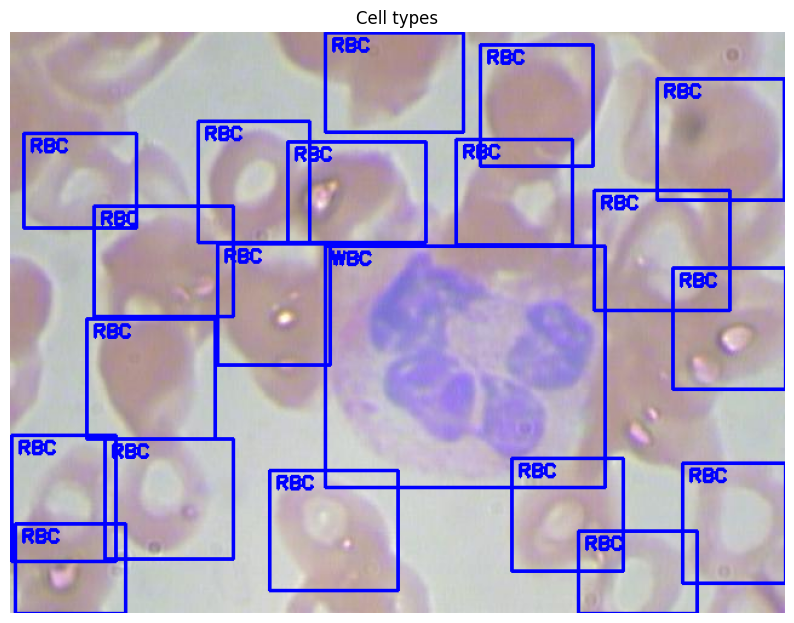

In [ ]:
sample_image_file_name = f"BloodImage_{str(0).zfill(5)}"
sample_image_path = os.path.join("C:/Users/saibu/OneDrive/Desktop/DIP/Datasets/BCCD_Dataset-master/BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00000.jpg")
sample_annotations_path = os.path.join("C:/Users/saibu/OneDrive/Desktop/DIP/Datasets/BCCD_Dataset-master/BCCD_Dataset-master/BCCD/Annotations/BloodImage_00000.xml")

sample_image = read_image(sample_image_path)
sample_labels_file = read_text(sample_annotations_path)

bounding_boxes = find_bounding_boxes(sample_labels_file)
show_image_with_bounding_boxes(sample_image, "Cell types", bounding_boxes.get("items"))

### Extracting image vectors

Now, we will make a set of separate images with the different types of cells - RBC, WBC and platelets. The idea is to create samples for our classifier.

##### Resize

 We can have separate cell images in grayscale and resize them to the same size - 64 x 64 or (4096, 1) vector. While resizing we try to save the ratio and add some padding around the borders as we duplicate a little bit - cv2.BORDER_REPLICATE. Hopefully, the padding will not add too much artifacts. Also,unfortunately, in this way the differences with sizes will be lost, but we can add that afterwards as a subsequent feature. Although maybe in our dataset we do not have any knowledge of the magnification of the histology images, so we cannot calculate the size in $ \mu m $, which would be a better feature than pixels and it will be more robust for similar images from new datasets.

In [ ]:
def resize_to_closest_square_size(image, desired_size):
    """
    resize to the closest size to our desired one
    """
    old_width, old_height = image.shape
    ratio = float(desired_size) / max(old_width, old_height)
    new_width, new_height = int(old_width * ratio), int(old_height * ratio)
    image = cv2.resize(image, (new_width, new_height))
    return (image, new_width, new_height)

def resize_with_padding(image, desired_size, border_type = cv2.BORDER_REPLICATE):
    image, new_width, new_height = resize_to_closest_square_size(image, desired_size)

    delta_width = desired_size - new_width
    delta_height = desired_size - new_height

    top = delta_height//2
    bottom = delta_height - top
    left = delta_width//2
    right = delta_width - left

    color = [0, 0, 0]
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, border_type, value=color)
    return new_image


##### Preprocess cell image sample

 * Increase the contrast with CLAHE, as the image are little bit more brighter and most of their pixels have high values
 * Turn to grayscale - easier to work with one channel (maybe in further improvements it will be better to include the processing on all channels separately)

In [ ]:
def increase_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    l2 = clahe.apply(l)

    lab = cv2.merge((l2,a,b))
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return img2

def preprocess(image):
    image_with_increased_contrast = increase_contrast(image)

    gray_image = cv2.cvtColor(image_with_increased_contrast, cv2.COLOR_RGB2GRAY)

    return gray_image

def find_cell_edges(grayscale_image):
    smoothen_image = cv2.GaussianBlur(grayscale_image, (3, 3), 0)

    otsu_threshold, otsu_image = cv2.threshold(smoothen_image, 0, 255,
                                               cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_closed_otsu = cv2.morphologyEx(otsu_image, cv2.MORPH_CLOSE,
                                         structuring_element, iterations = 3)

    canny_image = cv2.Canny(image_closed_otsu, otsu_threshold, 0.1*otsu_threshold)

    return canny_image

##### Image vectors with labels

Now, we will extract the image vectors with their labels from all the images of the datasets - around 410

In [ ]:
class CellImage:

    def __init__(self, image, base_file_name):
        self.original_image = image
        self.base_file_name = base_file_name

    def resize(self, dimension):
        processed_image = preprocess(self.original_image)
        resized_image = resize_with_padding(processed_image, dimension)
        return resized_image

    def size(self):
        return self.original_image.shape

In [ ]:
def crop_image(image, xmin, xmax, ymin, ymax):
    # check for incorrect annotations of the bounding box
    if(ymax - ymin > 0 and xmax - xmin > 0):
        cropped_image = image[ymin:ymax, xmin:xmax]
        return cropped_image
    else:
        return None

def get_cell_image_by_bounding_box(image, bounding_box, dimension):
    return crop_image(image,
                      bounding_box.xmin,
                      bounding_box.xmax,
                      bounding_box.ymin,
                      bounding_box.ymax)


def extract_image_samples():

    min_index, max_index = 0, 411
    dimension = 64

    images_count = max_index - min_index
    images = np.array([])
    labels = np.array([])

    for i in range(min_index, max_index):
        # images & annotations paths
        image_file_name = f"BloodImage_{str(i).zfill(5)}"
        image_path = os.path.join("C:/Users/saibu/OneDrive/Desktop/DIP/Datasets/BCCD_Dataset-master/BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00000.jpg")
        annotations_path = os.path.join("C:/Users/saibu/OneDrive/Desktop/DIP/Datasets/BCCD_Dataset-master/BCCD_Dataset-master/BCCD/Annotations/BloodImage_00000.xml")

        # read data - images with annotations
        image = read_image(image_path)
        text = read_text(annotations_path)

        # check for missing images with the sequential indices
        if (image is not None and text is not None):
            bounding_boxes = find_bounding_boxes(text).get('items')

            if(len(bounding_boxes) > 0):
                for bounding_box in bounding_boxes:
                    cropped_cell = get_cell_image_by_bounding_box(image, bounding_box, dimension)

                    if(cropped_cell is not None):
                        images = np.append(images, CellImage(cropped_cell, image_file_name))
                        labels = np.append(labels, bounding_box.label)

    return images, labels


In [ ]:
start_time = time.time()

cell_images, cell_labels = extract_image_samples()

print("Images shape:", cell_images.shape)
print("Labels shape:", cell_labels.shape)

end_time = time.time()
elapsed_time = end_time - start_time
print("Total elapsed time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

#### Features

Apart from the actual image vector (64 x 64), we can try to retrieve other features for the classification.

* HOG
* Size of the bounding box
* Mean color intensity

Although maybe the size and the colour are not the best features as they depend heavily on this particular dataset - its dimensions and colour marking.

##### HOG






In [ ]:
def get_hog_features(image):
  cell_size = (8, 8)
  block_size = (2, 2)
  bins_number = 8

  # win_size = the size of the image cropped to an multiple of the cell size
  # cell_size = the size of the cells of the img patch over which to calculate the histograms
  # block_size = the number of cells which fit in the patch
  hog = cv2.HOGDescriptor(_winSize = img.shape,
                          _blockSize = (block_size[0] * cell_size[0], block_size[1] * cell_size[1]),
                          _blockStride = cell_size,
                          _cellSize = cell_size,
                          _nbins = bins_number)


  hist = hog.compute(img)
  return hist.reshape(1, -1)[0]

### Creating DataFrame

First, we try to visualize a couple of images generated by the extraction and look at the possible features we can extract from then e.g. the hog descriptor. Unfortunately, we cannot use contour features for the cells as our edge detection is not very successful.

In [ ]:
def show_images(images, titles, fig_title=None, fig_width = 13, fig_height = 5):
    assert(len(images) == len(titles))

    fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
    fig.suptitle(fig_title, fontsize = 20)

    i = 1
    for image, title in zip(images, titles):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title , fontsize = 20)
        plt.axis('off')
        i += 1


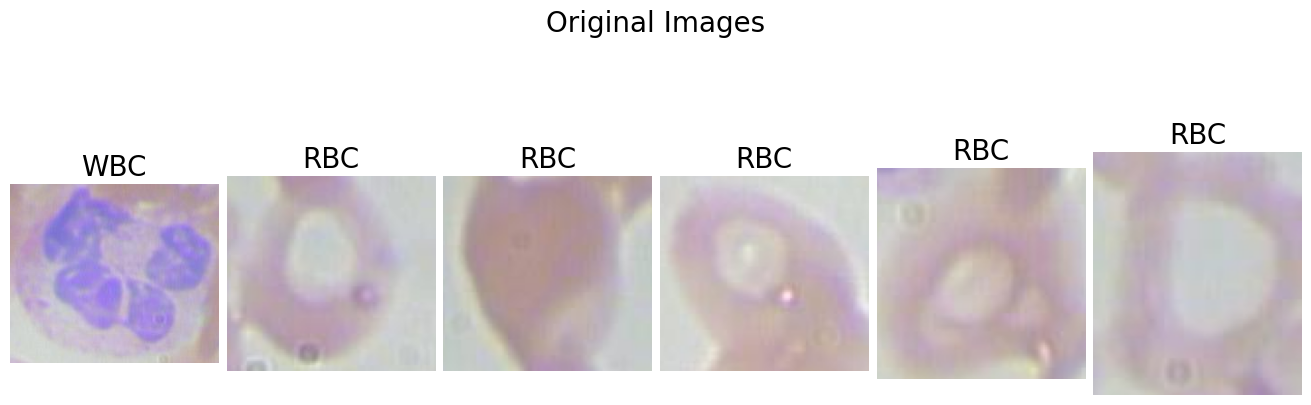

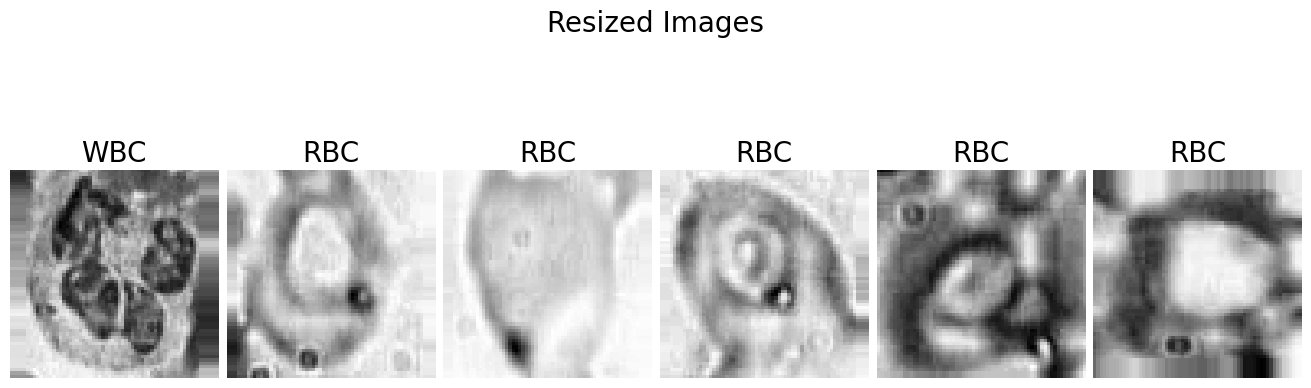

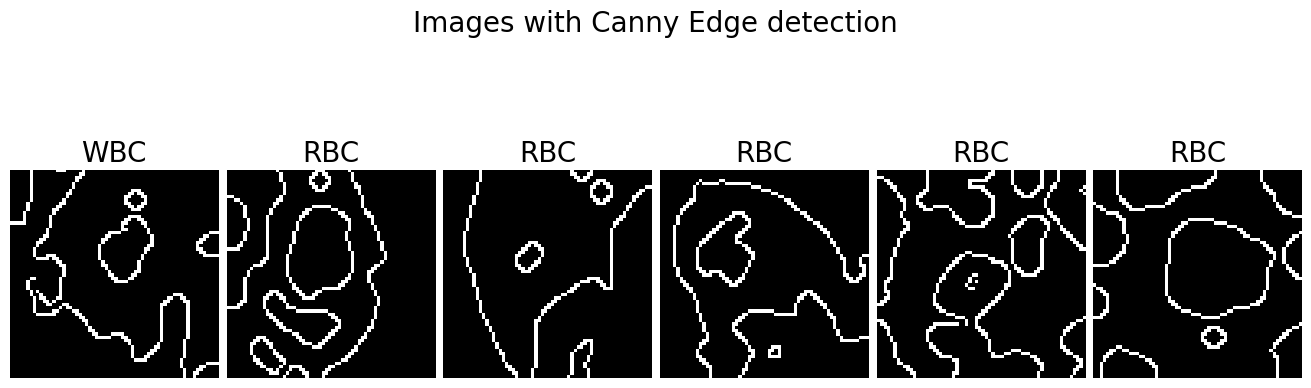

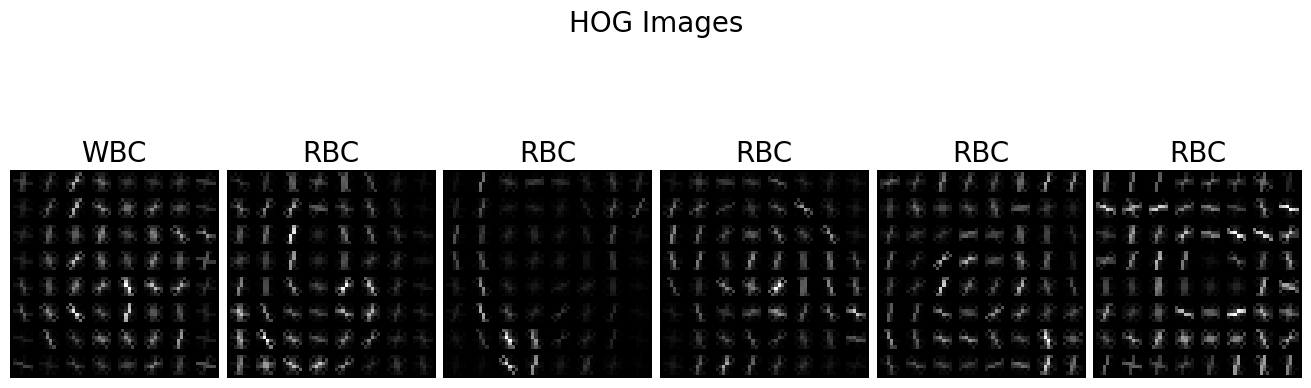

In [ ]:
def contours(image):
  img = image.copy()
  contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
  return img

def hog_skimage(img):
  # the normalization is different than opencv and it is slower
  (hog, hog_image) = feature.hog(img,
                                 orientations=8,
                                 pixels_per_cell=(8, 8),
                                 cells_per_block=(2, 2),
                                 block_norm='L2-Hys',a
                                 visualize=True)
  return hog_image

range_cells = range(0, 6)

sample_cells = [img.original_image for img in cell_images[range_cells]]
sample_resized_cells = [img.resize(64) for img in cell_images[range_cells]]
sample_canny_cells = [find_cell_edges(img) for img in sample_resized_cells]
#sample_contours_cells = [contours(img) for img in sample_canny_cells]
sample_hog_cells = [hog_skimage(img) for img in sample_resized_cells]

show_images(sample_cells, cell_labels[range_cells], fig_title="Original Images")
show_images(sample_resized_cells, cell_labels[range_cells], fig_title="Resized Images")
show_images(sample_canny_cells, cell_labels[range_cells], fig_title="Images with Canny Edge detection")
#show_images(sample_contours_cells, labels[range_cells], fig_title="Images with Contours")
show_images(sample_hog_cells, cell_labels[range_cells], fig_title="HOG Images")


In [ ]:
data = []
for cell_image, cell_label in zip(cell_images, cell_labels):
  img = cell_image.resize(64)
  hog_features = get_hog_features(np.float32(img))
  hog_features = hog_features
  w, h, _ = cell_image.original_image.shape
  bgr = cv2.mean(cell_image.original_image)

  data.append([np.float32(img.flatten()), hog_features, w, h, bgr[2], bgr[1], bgr[0], cell_label])

cells_data = pd.DataFrame(data, columns=["image_vector",
                                         "hog",
                                         "bounding_box_width",
                                         "bounding_box_height",
                                         "mean_red_color_intensity",
                                         "mean_blue_color_intesity",
                                         "mean_green_color_intensity",
                                         "cell_type"])

Let's see our generated dataframe

In [ ]:
cells_data.head()

,image_vector,hog,bounding_box_width,bounding_box_height,mean_red_color_intensity,mean_blue_color_intesity,mean_green_color_intensity,cell_type
0,"[122.0, 122.0, 122.0, 122.0, 122.0, 134.0, 151...","[0.2547731, 0.2032445, 0.07960535, 0.18786466,...",199,231,200.864474,163.922230,179.993735,WBC
1,"[251.0, 251.0, 251.0, 250.0, 250.0, 247.0, 247...","[0.07027937, 0.03790084, 0.027970433, 0.056500...",99,106,192.074138,187.778826,194.654183,RBC
2,"[246.0, 246.0, 246.0, 245.0, 247.0, 248.0, 251...","[0.36195856, 0.17690839, 0.01138193, 0.0100155...",99,106,170.396131,170.316276,184.612540,RBC
3,"[250.0, 250.0, 250.0, 250.0, 250.0, 248.0, 250...","[0.17089017, 0.12056773, 0.13241237, 0.0411664...",99,106,192.618258,191.363065,203.471603,RBC
4,"[155.0, 146.0, 149.0, 150.0, 152.0, 165.0, 179...","[0.14224343, 0.15314695, 0.21872672, 0.2359093...",93,92,180.636746,179.222651,194.761805,RBC


It is a good idea to save the extracted features in order to reuse them and not to perform the whole process of feature extraction during modelling.

In [ ]:
with open(cells_data_file, 'w') as f:
  cells_data.to_pickle(cells_data_file)

In [ ]:
#files.download(cells_data_file)

stored_cells_data = pd.read_pickle(cells_data_file)

# check that everything is retrieved successfully!
print("image vector size:", len(stored_cells_data.iloc[0].image_vector))
print("hog descriptor size:", len(stored_cells_data.iloc[0].hog))
print("Loaded cells data shape:", stored_cells_data.shape)

stored_cells_data.head()

image vector size: 4096
hog descriptor size: 1568
Loaded cells data shape: (4886, 8)


,image_vector,hog,bounding_box_width,bounding_box_height,mean_red_color_intensity,mean_blue_color_intesity,mean_green_color_intensity,cell_type
0,"[122.0, 122.0, 122.0, 122.0, 122.0, 134.0, 151...","[0.2547731, 0.2032445, 0.07960535, 0.18786466,...",199,231,200.864474,163.922230,179.993735,WBC
1,"[251.0, 251.0, 251.0, 250.0, 250.0, 247.0, 247...","[0.07027937, 0.03790084, 0.027970433, 0.056500...",99,106,192.074138,187.778826,194.654183,RBC
2,"[246.0, 246.0, 246.0, 245.0, 247.0, 248.0, 251...","[0.36195856, 0.17690839, 0.01138193, 0.0100155...",99,106,170.396131,170.316276,184.612540,RBC
3,"[250.0, 250.0, 250.0, 250.0, 250.0, 248.0, 250...","[0.17089017, 0.12056773, 0.13241237, 0.0411664...",99,106,192.618258,191.363065,203.471603,RBC
4,"[155.0, 146.0, 149.0, 150.0, 152.0, 165.0, 179...","[0.14224343, 0.15314695, 0.21872672, 0.2359093...",93,92,180.636746,179.222651,194.761805,RBC


## Modelling

First, we will try to use only the raw image vectors.

 Image_vector column from the stored_cells_data DataFrame and converts it into a list using the tolist() method. The image_vector column
  contains the flattened image representations of the cell images

In [ ]:
cell_features = stored_cells_data.image_vector.tolist()
cell_labels = stored_cells_data.cell_type

#### Unbalanced dataset

Let's see what kind of samples do we have.

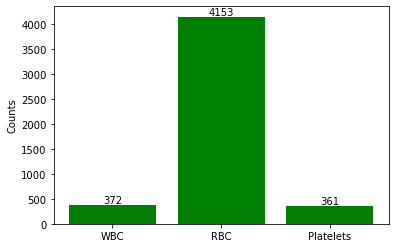

In [ ]:
counts = Counter(cell_labels)
unique_cell_types = np.unique(cell_labels)
x = list(np.arange(0,len(unique_cell_types)))
rects = plt.bar(x, counts.values(), color="green")
plt.xticks(x, counts.keys())
plt.ylabel('Counts')
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.,
             height,
             '%d' % int(height),
             ha='center',
             va='bottom')

plt.show()

We can see that we have highly imbalanced classes. It is a problem because possibly any classification algorithm will predict RBC with the greatest probability.
Possible solutions:
* Random Oversampling: randomly duplicate samples in the minority class
* Random Undersampling: randomly delete samples in the majority class

Of course, both of them have their pros and cons but
random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset. Actually in our case the data is representative as red cells are much more than white cells and platelets.

> RBCs account for approximately 40 to 45 percent of the blood. This percentage of blood made up of RBCs is a frequently measured number and is called the hematocrit. The ratio of cells in the normal blood is 600 RBCs for each white blood cell and 40 platelets. So, at least initially we will not try to perform any resampling on the training data.

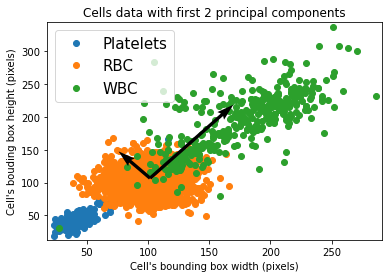

In [ ]:
pca_for_test = PCA(n_components=2, random_state=random_seed)
pca_for_test.fit_transform(stored_cells_data[["bounding_box_width",
                                              "bounding_box_height",
                                              "mean_red_color_intensity",
                                              "mean_blue_color_intesity",
                                              "mean_green_color_intensity"]])

eigen_vectors = pca_for_test.components_

for key, group in stored_cells_data.groupby(["cell_type"]):
    plt.plot(group["bounding_box_width"], group["bounding_box_height"],
               label=key, marker='o', linestyle="none")

# arrows showing the eigenvectors - PCA 1 and PCA 2
plt.quiver([np.mean(stored_cells_data.bounding_box_width)]*2,
           [np.mean(stored_cells_data.bounding_box_height)]*2,
           eigen_vectors[:, 1],
           eigen_vectors[:, 0],
           zorder=11,
           width=0.01,
           scale=3)

plt.legend(loc=0, fontsize=15)
plt.margins(0.02)
plt.xlabel("Cell's bounding box width (pixels)")
plt.ylabel("Cell's bouding box height (pixels)")
plt.title("Cells data with first 2 principal components");

Principle Components are the linear combinations of the original variables in the dataset. PCA allows us to transform the dataset into a new lower-dimensional subspace.



In [ ]:
print("Each cell image features shape:", cell_features[0].shape)

images_pca = PCA(n_components=100, random_state=random_seed)
pca_fit = images_pca.fit(cell_features)
pcas = pca_fit.transform(cell_features)

print("Each cell image PCAs shape:", pcas[0].shape)

Each cell image features shape: (4096,)
Each cell image PCAs shape: (100,)


Now we can see a couple of the basis vectors, although they are not very comprehensive for us:

The number of the principal components: 100


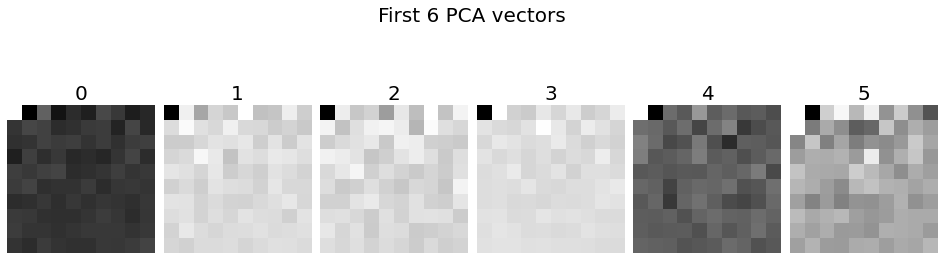

In [ ]:
print("The number of the principal components:", len(pcas[0]))
pca_images = [im.reshape(10, 10) for im in pcas]
show_images(pca_images[0:6], np.arange(0, 6), "First 6 PCA vectors")

Actually we can see how much information is preserved with PCA. It is close to 95%.

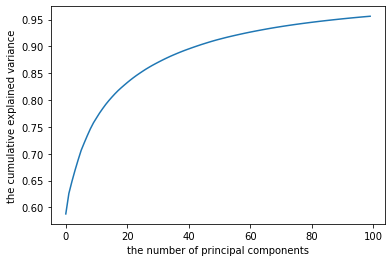

In [ ]:
plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
plt.xlabel('the number of principal components')
plt.ylabel('the cumulative explained variance')
plt.show()

We can also see the transformed images and how much information they have preserved visually.

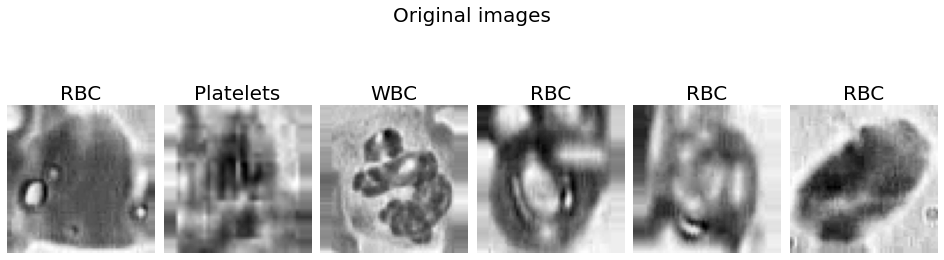

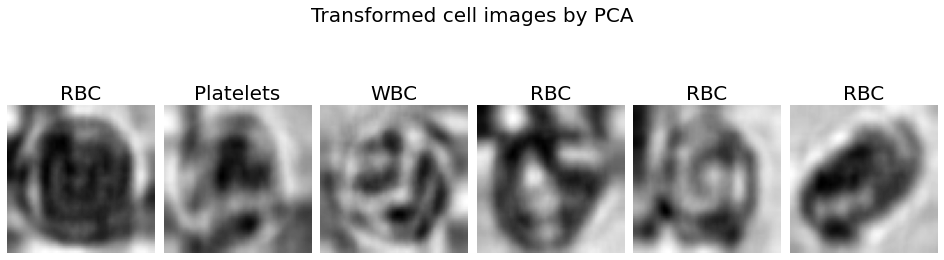

In [ ]:
transformed_cells = [im.reshape(64, 64) for im in cell_features]
reversed_images = [im.reshape(64, 64) for im in pca_fit.inverse_transform(pcas)]

show_images(transformed_cells[70:76], cell_labels[70:76], "Original images")
show_images(reversed_images[70:76], cell_labels[70:76], "Transformed cell images by PCA")

In [ ]:
# update cell features
cell_features = pcas

### Logistic Regression - baseline

As Logistic Regression is one of the basic simple and most commonly used ML algorithms, we can use it as a baseline for our modelling. Actually, Logistic Regression is used for binary classification i.e. two-class classification. It describes and estimates the relationship between one dependent binary variable and an independent one.

However, in our case we have three classes and we will use the multinomial logistic regression i.e. the target variable has three or more nominal categories such as predicting types of cells. Multinomial logistic regression uses again a linear function.



In [ ]:
lr = LogisticRegression(C = 1,
                        multi_class="multinomial",
                        solver="saga", # improved linear convergence
                        max_iter=2000)

lr_cells_train, lr_cells_test, lr_labels_train, lr_labels_test = train_test_split(cell_features,
                                                                                  cell_labels,
                                                                                  test_size=0.25,
                                                                                  stratify=cell_labels,
                                                                                  random_state=random_seed)
print(lr_cells_train.shape)
print(lr_labels_train.shape)
print(lr_cells_test.shape)
print(lr_labels_test.shape)

lr_res = lr.fit(lr_cells_train, lr_labels_train)

(3664, 100)
(3664,)
(1222, 100)
(1222,)


In [ ]:
def show_scores(estimator, X_train, y_train, X_test, y_test):
  #return the mean accuracy on the given test data and labels.
  print("Train: ", estimator.score(X_train, y_train))
  print("Test: ", estimator.score(X_test, y_test))

In [ ]:
show_scores(lr, lr_cells_train, lr_labels_train, lr_cells_test, lr_labels_test)

Train:  0.7505458515283843
Test:  0.7422258592471358


In [ ]:
def show_confusion_matrices_and_report(estimator, X, y):

  predicted = estimator.predict(X)
  print(f"Classification report for classifier:\n {classification_report(y, predicted)}")

  matrix = plot_confusion_matrix(estimator, X, y,
                               cmap=plt.cm.Greens,
                               normalize='true')
  plt.title('Confusion matrix for our classifier in percentage')
  plt.show(matrix)

  matrix_num = plot_confusion_matrix(estimator, X, y, cmap=plt.cm.Greens)
  plt.title('Confusion matrix for our classifier with actual sample counts')
  plt.show(matrix_num)

  plt.show()

Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.32      0.83      0.47        90
         RBC       1.00      0.73      0.85      1039
         WBC       0.31      0.76      0.44        93

    accuracy                           0.74      1222
   macro avg       0.54      0.78      0.58      1222
weighted avg       0.90      0.74      0.79      1222



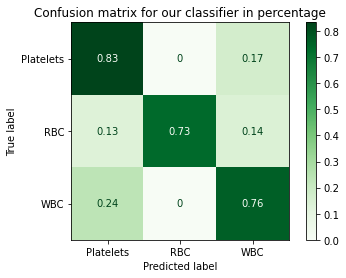

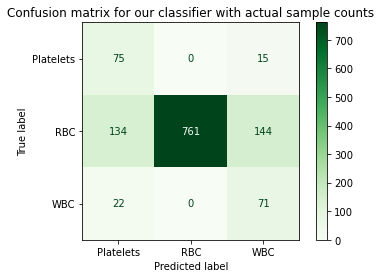

In [ ]:
show_confusion_matrices_and_report(lr, lr_cells_test, lr_labels_test)

As a whole, as a simple algorithm Linear Regression performs quite well as a percentage of the predicted cell types. It predicts a lot of WBCs and Platelets, not only RBCs but unfortunalely the precision is quite low.
There are a lot of false possitives i.e. RBCs which are defined as WBCs and Platelets. Overall, it is not a very good result as actually the occurence of more WBCs is a sign of a disease.

### SVM



> *Hyperparameters*
> * gamma - how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’
> * C - regularisation -> for larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly; a lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy




In [ ]:
svm_cells_train, svm_cells_test, svm_labels_train, svm_labels_test = train_test_split(cell_features,
                                                                                      cell_labels,
                                                                                      test_size=0.25,
                                                                                      stratify=cell_labels,
                                                                                      random_state=random_seed)
print(svm_cells_train.shape)
print(svm_labels_train.shape)
print(svm_cells_test.shape)
print(svm_labels_test.shape)

(3664, 100)
(3664,)
(1222, 100)
(1222,)


In [ ]:
svm = SVC(kernel='rbf',
          C = 1, #default
          gamma="scale", # default = 1 / (n_features * X.var())
          class_weight="balanced",
          decision_function_shape="ovr", #only option, ovo deprecated
          random_state=random_seed,
          probability=True)
svm.fit(svm_cells_train, svm_labels_train)

SVC(C=1, class_weight='balanced', probability=True, random_state=27)

We have quite a small value of gamma, so in this way we have a smoother decision boundary as more points, not just the ones closer to the support vectors, influence it.

In [ ]:
print("Gamma hyperparameter:", 1 / (len(svm_cells_train) * svm_cells_train.var()))

Gamma hyperparameter: 6.5563730780534664e-09


#### Scoring

Classification report for classifier:
               precision    recall  f1-score   support

   Platelets       0.74      0.81      0.78        90
         RBC       1.00      0.98      0.99      1039
         WBC       0.82      0.88      0.85        93

    accuracy                           0.96      1222
   macro avg       0.85      0.89      0.87      1222
weighted avg       0.97      0.96      0.96      1222



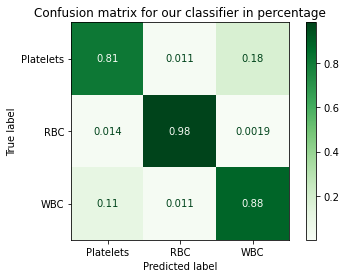

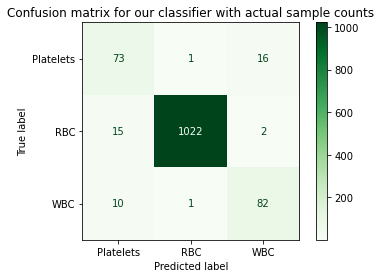

In [ ]:
show_confusion_matrices_and_report(svm, svm_cells_test, svm_labels_test)

* It seems that the result is similar to the baseline logistic regression maybe a little bit better. Actually, if we look at the percentage of predicted WBCs and Platelets the classifier seems to perform quite well. Even the precision is definitely higher than the one of LogisticRegression

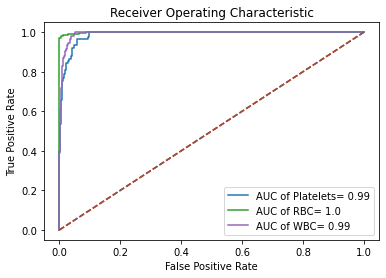

In [ ]:
def get_index(class_name):
  return np.where(svm.classes_ == class_name)[0][0]

probabilities = svm.predict_proba(svm_cells_test)
#print(svm.classes_)

for class_name in svm.classes_:
  y_proba = probabilities[:, get_index(class_name)]
  false_positive_rate, true_positive_rate, thresholds = roc_curve(svm_labels_test, y_proba, pos_label=class_name)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label=f'AUC of {class_name}= {round(roc_auc, 2)}')
  plt.plot([0,1], [0,1], ls='--')

plt.title('Receiver Operating Characteristic')

plt.legend(loc=0)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [ ]:
filename = 'finalized_model.sav'
joblib.dump(svm, filename)

['finalized_model.sav']

Actual cell types:  ['RBC', 'Platelets', 'Platelets', 'Platelets', 'WBC', 'RBC']


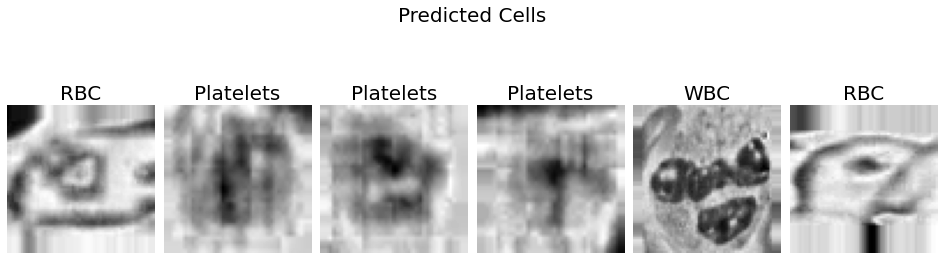

In [ ]:
#Just for visualisation purpose
range_cells = np.arange(100, 106)

sample_cells = [img.reshape(64, 64) for img in stored_cells_data.image_vector[range_cells]]
predicted_labels = svm.predict(cell_features[range_cells]).tolist()
print("Actual cell types: ", cell_labels[range_cells].tolist())

show_images(sample_cells, predicted_labels, fig_title="Predicted Cells")

# Object Detection

In [ ]:
def get_cell_features(cell_image):
    preprocessed_cell = preprocess(cell_image)
    resized_cell = resize_with_padding(preprocessed_cell, 64)
    cell_pca = pca_fit.transform([resized_cell.flatten()])
    return cell_pca

def get_possible_cells_bounding_boxes(image, image_edges, estimator):
  img = image.copy()
  cells = []
  contours, hierarchy = cv2.findContours(image_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  for contour, cv_hierarchy in zip(contours, hierarchy[0]):
    contour_area = cv2.contourArea(contour)
    has_parent = cv_hierarchy[3] > 0
    if (contour_area > 30 and not(has_parent)):

      x, y, w, h = cv2.boundingRect(contour)
      xmin, xmax, ymin, ymax = x, x+w, y, y+h

      cell_image = crop_image(img, xmin, xmax, ymin, ymax)

      predicted_cell_type = estimator.predict(get_cell_features(cell_image))[0]

      cells.append(BoundingBox(xmin, xmax, ymin, ymax, predicted_cell_type))

  return cells

def show_image_with_predicted_bounding_boxes(sample_img, estimator):
  sample_grayscale_image = preprocess(sample_img)
  sample_image_with_edges = find_cell_edges(sample_grayscale_image)

  possible_cells_bbs = get_possible_cells_bounding_boxes(sample_img, sample_image_with_edges, estimator)
  show_image_with_bounding_boxes(sample_img, "Detected cells with predicted cell types", possible_cells_bbs)

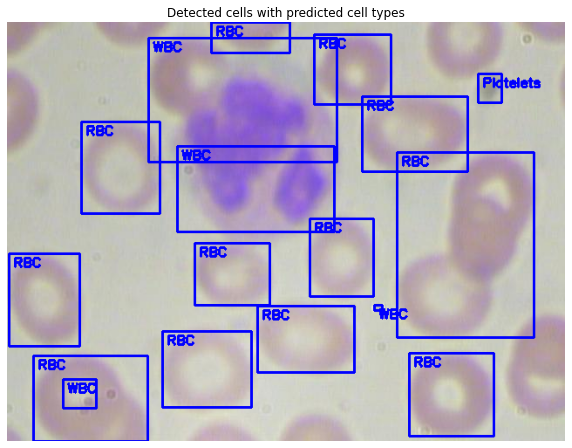

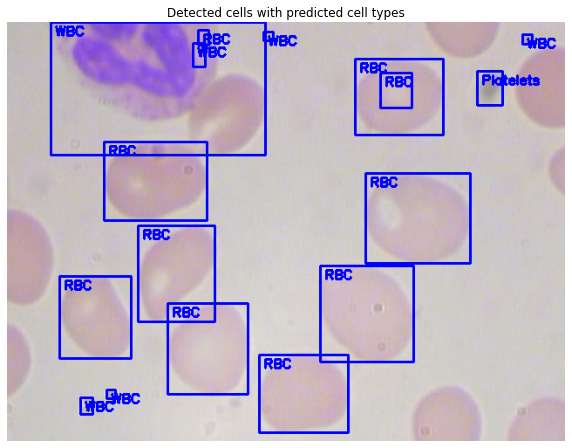

In [ ]:
img_indices = [398, 388]
for img_index in img_indices:

  sample_img_file_name = f"BloodImage_{str(img_index).zfill(5)}"
  sample_img_path = os.path.join(DATASET_FOLDER, "JPEGImages", f"{sample_img_file_name}.jpg")
  sample_img = read_image(sample_img_path)

  show_image_with_predicted_bounding_boxes(sample_img, svm)

Also, it may be interesting to see how it will perform on a complete different dataset - different cells marking and dimenstions.

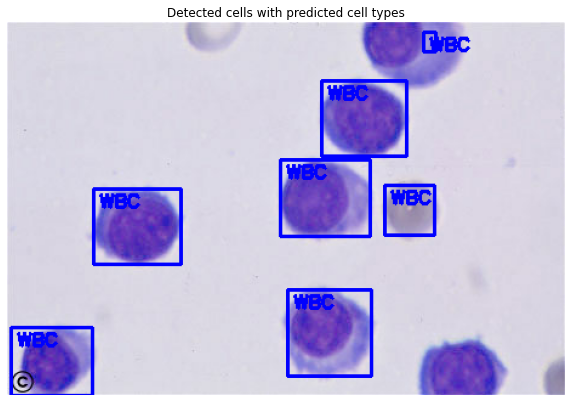

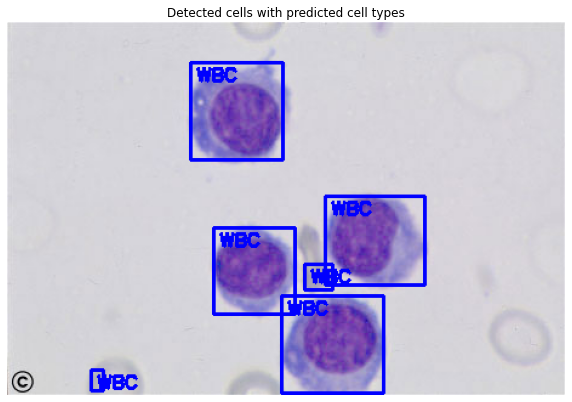

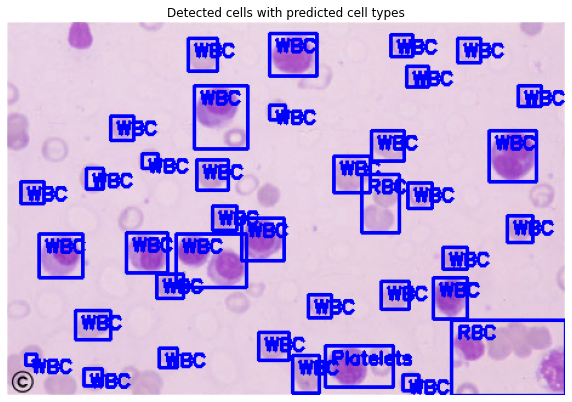

In [ ]:
for i in range(46, 46+3):
    test_image = read_image(os.path.join(DATASET2_FOLDER, f"{str(i)}.jpg"))

    show_image_with_predicted_bounding_boxes(test_image, svm)

The blood smears really consist of more WBCs, as they are from cases of leucemia but there are a lot of false positive predictions, as well.